In [1]:
import pandas as pd
import numpy as np

In [2]:
import sklearn


In [3]:
columns_drop_metmast = ['Min_Raindetection', 'Avg_Raindetection', 'Avg_Raindetection', 'Anemometer1_Freq', 'Anemometer1_Offset', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset', 'Anemometer2_Freq', 'Anemometer2_Offset', 'Anemometer2_CorrGain', 'Anemometer2_CorrOffset', 'DistanceAirPress', 'AirRessureSensorZeroOffset']
columns_drop_signals = ['Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2']


In [4]:
df_failures = pd.read_csv(r'../rawdata/wind-farm-1-failures-training.csv', sep=';')


In [200]:
df_signals = pd.read_csv('../rawdata/wind-farm-1-signals-training.csv', sep=';')#, nrows=100000)
df_signals.columns

Index(['Turbine_ID', 'Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg',
       'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg',
       'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max',
       'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std',
       'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg',
       'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
       'Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_TotActPwr',
       'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
       'Prod_LatestAvg_ReactPwrGen2', 'Prod_LatestAvg_TotReactPwr',
       'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg',
       'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg',
       'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg',
       'Gen_SlipRing_Temp_Avg', 'Spin

In [201]:
columns_gen=['Turbine_ID','Timestamp',
             
             'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
            
            'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
      # 'Prod_LatestAvg_ActPwrGen2', 
             
             'Prod_LatestAvg_TotActPwr',
       'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
      # 'Prod_LatestAvg_ReactPwrGen2',
             
             'Prod_LatestAvg_TotReactPwr',
             
             'Gen_SlipRing_Temp_Avg',
             
             'Gen_Bear2_Temp_Avg'
            ]

In [202]:

df_signals = df_signals.drop(columns=columns_drop_signals)
df_signals = df_signals[columns_gen]
df_signals['Timestamp']=pd.to_datetime(df_signals['Timestamp']).dt.tz_convert(None)
df_signals.head()

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_TotReactPwr,Gen_SlipRing_Temp_Avg,Gen_Bear2_Temp_Avg
0,T11,2016-01-01,1339.4,1233.3,1270.9,18.8,42.0,59,61,60,0,41059.0,41059.0,0,-13521,-13521,27,38
1,T06,2016-01-01,1270.0,1232.8,1248.5,6.8,42.0,51,52,53,0,10465.0,10465.0,0,-12621,-12621,26,35
2,T01,2016-01-01,1277.4,1226.1,1249.0,9.0,41.0,58,59,58,-107,4420.0,4313.0,-99,-5636,-5735,25,37
3,T09,2016-01-01,1376.7,1234.3,1272.0,24.7,40.0,58,57,58,0,33173.0,33173.0,0,-13513,-13513,26,33
4,T07,2016-01-01,1317.5,1229.5,1254.9,13.8,41.0,62,62,61,0,18831.0,18831.0,0,-11991,-11991,26,39


In [203]:
df_signals.shape

(434145, 18)

1-dataset tem de estar ordenado primeiro por turbina e depois por timestamp (ascendente)

In [204]:
def subsample_sequence(df, length, turbine):
        
    last_possible = df[df['Turbine_ID']==turbine].shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[df['Turbine_ID']==turbine][random_start: random_start+length]

    return df_sample



In [205]:

def split_subsample_sequence(df, length, target, turbine):

              
    df_subsample = subsample_sequence(df, length, turbine)
    y_sample = df_subsample.iloc[df_subsample.shape[0]-1][target]
    
    
    X_sample = df_subsample[0:df_subsample.shape[0]].drop(columns=[target,'Turbine_ID','Timestamp'])
    X_sample = X_sample.values
    
    return np.array(X_sample), np.array(y_sample)

In [206]:
def get_X_y(df, number_of_sequences, length, target):
    X, y = [], []
    
    for turbine in ['T01','T06', 'T07', 'T09', 'T11']:

        for i in range(number_of_sequences):
            xi, yi = split_subsample_sequence(df, length, target, turbine)
            X.append(xi)
            y.append(yi)

    X = np.array(X)
    y = np.array(y)
        
    return X, y

In [207]:
#1º argumento: dataframe
#2º argumento: número de sequencias a gerar para cada uma das turbinas
#3º argumento: comprimento de cada uma das sequências (nº de timestamps recolhidos para formar uma sequencia)
#4º argumento: especificar a variavel target
    
#get_X_y(df_signals,3, 4, 'Gen_RPM_Max')

In [208]:
X, y = get_X_y(df_signals,3, 4, 'Gen_RPM_Max')

In [209]:
print(np.shape(X))


(15, 4, 15)


In [210]:
import numpy as np

In [211]:
from tensorflow.keras.callbacks import EarlyStopping


In [21]:
df_signals.head()

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg
0,T11,2016-01-01 00:00:00+00:00,1339.4,1233.3,1270.9,18.8,42.0,59
1,T06,2016-01-01 00:00:00+00:00,1270.0,1232.8,1248.5,6.8,42.0,51
2,T01,2016-01-01 00:00:00+00:00,1277.4,1226.1,1249.0,9.0,41.0,58
3,T09,2016-01-01 00:00:00+00:00,1376.7,1234.3,1272.0,24.7,40.0,58
4,T07,2016-01-01 00:00:00+00:00,1317.5,1229.5,1254.9,13.8,41.0,62


In [22]:
df_target.head()

,Timestamp,Turbine_ID,Fail_60_GEARBOX,Fail_60_GENERATOR,Fail_60_GENERATOR_BEARING,Fail_60_TRANSFORMER,Fail_60_HYDRAULIC_GROUP,Fail_50_GEARBOX,Fail_50_GENERATOR,Fail_50_GENERATOR_BEARING,...,Fail_20_GEARBOX,Fail_20_GENERATOR,Fail_20_GENERATOR_BEARING,Fail_20_TRANSFORMER,Fail_20_HYDRAULIC_GROUP,Fail_10_GEARBOX,Fail_10_GENERATOR,Fail_10_GENERATOR_BEARING,Fail_10_TRANSFORMER,Fail_10_HYDRAULIC_GROUP
0,2016-01-01 00:00:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-01 00:10:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-01 00:20:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2016-01-01 00:30:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-01 00:40:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_target=pd.read_csv('df_target_v2_60_50_40_50_30_20_10.csv', index_col=[0])
df_target['Timestamp']=pd.to_datetime(df_target['Timestamp'])
df_target.head()

,Timestamp,Turbine_ID,Fail_60_GEARBOX,Fail_60_GENERATOR,Fail_60_GENERATOR_BEARING,Fail_60_TRANSFORMER,Fail_60_HYDRAULIC_GROUP,Fail_50_GEARBOX,Fail_50_GENERATOR,Fail_50_GENERATOR_BEARING,...,Fail_20_GEARBOX,Fail_20_GENERATOR,Fail_20_GENERATOR_BEARING,Fail_20_TRANSFORMER,Fail_20_HYDRAULIC_GROUP,Fail_10_GEARBOX,Fail_10_GENERATOR,Fail_10_GENERATOR_BEARING,Fail_10_TRANSFORMER,Fail_10_HYDRAULIC_GROUP
0,2016-01-01 00:00:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-01 00:10:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-01 00:20:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2016-01-01 00:30:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-01 00:40:00,T01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [274]:
target='Fail_10_GENERATOR'
df_signals_target=pd.merge(df_signals, df_target[['Timestamp','Turbine_ID',target]], how='left', on=['Turbine_ID','Timestamp'])

In [275]:
df_signals_target.Gen_Bear_Temp_Avg.fillna(0,inplace=True)

In [276]:
2500*0.2

500.0

In [277]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [278]:
len_ = int(0.8*df_signals_target.shape[0])

df_train = df_signals_target[:len_]
df_test = df_signals_target[len_:]

In [279]:
var_list=list(df_train.drop(columns=['Turbine_ID', 'Timestamp',target]).columns)

In [280]:
var_list

['Gen_RPM_Max',
 'Gen_RPM_Min',
 'Gen_RPM_Avg',
 'Gen_RPM_Std',
 'Gen_Bear_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Prod_LatestAvg_ActPwrGen0',
 'Prod_LatestAvg_ActPwrGen1',
 'Prod_LatestAvg_TotActPwr',
 'Prod_LatestAvg_ReactPwrGen0',
 'Prod_LatestAvg_ReactPwrGen1',
 'Prod_LatestAvg_TotReactPwr',
 'Gen_SlipRing_Temp_Avg',
 'Gen_Bear2_Temp_Avg']

In [281]:
scaler = StandardScaler()

for i in var_list:
    df_train[i]=scaler.fit_transform(df_train[[i]])
    df_test[i]=scaler.transform(df_test[[i]])

df_train.head()

<ipython-input-281-590c48b68ed8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[i]=scaler.fit_transform(df_train[[i]])
<ipython-input-281-590c48b68ed8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[i]=scaler.transform(df_test[[i]])
<ipython-input-281-590c48b68ed8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

<ipython-input-281-590c48b68ed8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[i]=scaler.transform(df_test[[i]])
<ipython-input-281-590c48b68ed8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[i]=scaler.fit_transform(df_train[[i]])
<ipython-input-281-590c48b68ed8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_TotReactPwr,Gen_SlipRing_Temp_Avg,Gen_Bear2_Temp_Avg,Fail_10_GENERATOR
0,T11,2016-01-01,0.258079,0.510634,0.357229,-0.440904,-0.231705,-0.147832,-0.069120,-0.091975,0.599216,-0.432245,-0.427453,0.503068,0.139007,0.169069,-0.198930,-0.302107,0
1,T06,2016-01-01,0.150275,0.509819,0.321008,-0.549176,-0.231705,-0.431648,-0.399373,-0.353410,0.599216,-0.708180,-0.702608,0.503068,0.205249,0.237161,-0.317190,-0.516810,0
2,T01,2016-01-01,0.161770,0.498901,0.321816,-0.529326,-0.287618,-0.183309,-0.142509,-0.166671,0.437648,-0.762701,-0.757938,0.359128,0.719361,0.758148,-0.435449,-0.373675,0
3,T09,2016-01-01,0.316021,0.512264,0.359008,-0.387669,-0.343532,-0.183309,-0.215899,-0.166671,0.599216,-0.503371,-0.498378,0.503068,0.139595,0.169674,-0.317190,-0.659946,0
4,T07,2016-01-01,0.224060,0.504441,0.331357,-0.486017,-0.287618,-0.041400,-0.032425,-0.054627,0.599216,-0.632725,-0.627367,0.503068,0.251618,0.284827,-0.317190,-0.230539,0


In [282]:
#Guia para utilização da função final get_X_y:

#1º argumento: dataframe
#2º argumento: número de sequencias a gerar para cada uma das turbinas
#3º argumento: comprimento de cada uma das sequências (nº de timestamps recolhidos para formar uma sequencia)
#4º argumento: especificar a variavel target

numero_de_dias=15

Nvezes_10_minutos=6*24*numero_de_dias

import sequences_generator 
print(Nvezes_10_minutos)


X_train,y_train=sequences_generator.get_X_y(df_train,2000,Nvezes_10_minutos,target)

X_test,y_test=sequences_generator.get_X_y(df_test,500,Nvezes_10_minutos,target)


2160


In [283]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

def init_model():
    
    model = models.Sequential()
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    #model.add(layers.Dense(1, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                   #metrics=['accuracy'])
                  metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC()])
    
    return model

In [284]:
neg=int(pd.DataFrame(y_train).value_counts()[0])
pos=int(pd.DataFrame(y_train).value_counts()[1])
total=neg+pos

In [285]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [286]:
X_train.shape

(10000, 2160, 16)

In [287]:
#int(pd.DataFrame(y).value_counts()[1])

In [288]:
class_weight

{0: 0.5094243504839532, 1: 27.027027027027028}

In [289]:

#X_train, y_train = X, y


from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(monitor='val_auc_10', mode='max', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.3,
            epochs=100, 
            batch_size=32
            ,callbacks=[es]
            ,class_weight=class_weight
                   )

Epoch 1/100
219/219 [==============================] - 7858s 36s/step - loss: 0.7107 - recall_19: 0.4286 - precision_2: 0.0825 - auc_11: 0.7653 - val_loss: 0.3998 - val_recall_19: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_auc_11: 0.1651
Epoch 2/100
219/219 [==============================] - 686s 3s/step - loss: 0.6027 - recall_19: 0.7857 - precision_2: 0.0931 - auc_11: 0.8699 - val_loss: 0.2545 - val_recall_19: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_auc_11: 0.2283
Epoch 3/100
219/219 [==============================] - 3997s 18s/step - loss: 0.6061 - recall_19: 0.8247 - precision_2: 0.1204 - auc_11: 0.8801 - val_loss: 0.2763 - val_recall_19: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_auc_11: 0.1805
Epoch 4/100
219/219 [==============================] - 581s 3s/step - loss: 0.5512 - recall_19: 0.8636 - precision_2: 0.1212 - auc_11: 0.9010 - val_loss: 0.3107 - val_recall_19: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_auc_11: 0.1776
Epoch 5/100
219/219 [===============

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_auc_10'])
plt.plot(history.history['val_precision_1'])
plt.plot(history.history['val_recall_18'])

plt.title('30_Generator')

In [272]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'Metric on the test set : {res[1]:.4f}')

Metric on the test set : 0.0000


In [273]:
res

[0.7387657165527344, 0.0, 0.0, 0.4396958351135254]

In [51]:
len(y_train)

4000

In [52]:
len(X_train)

4000

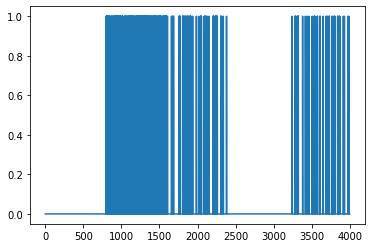

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y_train)